In [4]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
# Pickle it for later use
import pickle
sns.set()

In [5]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
# stop fuzzy charts
%config InlineBackend.figure_format = "retina"

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ='all'

In [8]:
df_fertiliser =  pd.read_pickle("../data/df_fertiliser.pkl")  
#tweets
df_tweets= pd.read_csv("../data/farmtweets.csv")   #farm tweets

## Modelling 

In [9]:
df_fertiliser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12144 entries, 0 to 12143
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   statistic        12144 non-null  object        
 1   date             12144 non-null  datetime64[ns]
 2   fertiliser_type  12144 non-null  category      
 3   unit             12144 non-null  object        
 4   value            6557 non-null   float64       
 5   month_year       12144 non-null  period[M]     
 6   month            12144 non-null  int64         
 7   year             12144 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(2), period[M](1)
memory usage: 676.3+ KB


In [10]:
#drop nan values for now

# Default configuration drops rows having at least 1 missing value
print('DataFrame after dropping the rows having missing values:')
df_fertiliser = df_fertiliser.dropna()

DataFrame after dropping the rows having missing values:


In [11]:
df_fertiliser.shape

(6557, 8)

## Splitting the dataset into the Training set and Test set

In [12]:
#keep date, fertiliser_type, month_year, month, year
X= df_fertiliser.drop(['fertiliser_type', 'statistic', 'unit'], axis=1) # feature matrix 
y = df_fertiliser['fertiliser_type']
class_labels = np.unique(y)

In [13]:
from sklearn.model_selection import train_test_split # Import train_test_split function [2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # 67% training and 33% test // found out by 1 - test_size = 1 - 0.33 = 0.67 -> 67%
X_train.shape, X_test.shape

((4393, 5), (2164, 5))

Because machine learning can only take input from numeric values so we need to factorise the data.

In [14]:
import category_encoders as ce

encoder = ce.OrdinalEncoder(cols=['date', 
                                  'month_year', 
                                  'month', 
                                  'year'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)


## Feature Scaling
For come of the columns there are some large numbers so I will apply feature scaling 

In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Label encoding

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test= label_encoder.fit_transform(y_test)

### Classsification of fertiliser type

#### DecisionTreeClassifier

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import accuracy_score

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [18]:
y_pred

array([ 3, 16,  9, ...,  7, 17, 20])

In [19]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head()

,Actual,Predicted
0,2,3
1,14,16
2,9,9
3,16,23
4,7,4


In [20]:
# import classification report module
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
# Summary of the predictions with class names of the streets
print(classification_report(y_test,  y_pred, target_names=class_labels))

                                    precision    recall  f1-score   support

   Ammonium Sulphate Nitrate (26%)       0.56      0.56      0.56        16
Calcium Ammonium Nitrate (27.5% N)       0.78      0.71      0.75       187
                  Compound 0-10-20       0.23      0.28      0.26       145
                   Compound 0-7-30       0.28      0.22      0.25       174
                 Compound 10-10-20       0.61      0.55      0.58       152
                  Compound 10-5-25       0.04      0.04      0.04        26
                  Compound 13-6-20       0.14      0.14      0.14        21
                  Compound 14-7-14       0.22      0.29      0.25       152
                  Compound 15-3-20       0.08      0.09      0.08        23
                  Compound 18-6-12       0.18      0.22      0.20       157
                  Compound 19-0-15       0.26      0.33      0.29        33
                  Compound 20-4-10       0.18      0.20      0.19        44
           

#### Results
First round, accuracy is 0.37. 

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# GridSearch cv

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# create a dictionary for the models and the parameters
model_params = {
      'desicion_tree': {
        'model': DecisionTreeClassifier(),  # decision tree classifier and parameters
        'params' : {
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),  # Random forest classifier and parameters
        'params' : {
            'n_estimators': [200, 500],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),   # N nearest neighbours and parameters
        'params' : {
            'n_neighbors':[5, 10, 20, 30, 40], 
            'metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis'],
            'weights':['uniform', 'distance' ]
            
        }
    },
    'logistic_regression' : {              # Logistic regression and parameters
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'solver':['newton-cg', 'lbfgs', 'liblinear'],
            'penalty': ['none', 'l1', 'l2', 'elasticnet'],
            'C': [1,5,10, 100]
        }
    }
}

In [22]:
#create a dataframe
scores = []


for model_name, mp in model_params.items():
    # create classifier with model and parameters
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    #fit to the model
    clf.fit(X_train,y_train)
    # add score into the dataset
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df_grid_search = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_grid_search

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8]})

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski', 'wminkowski', 'seuclidean',
                                    'mahalanobis'],
                         'n_neighbors': [5, 10, 20, 30, 40],
                         'weights': ['uniform', 'distance']})

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 5, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']})

,model,best_score,best_params
0,desicion_tree,0.308900,"{'criterion': 'entropy', 'max_depth': 8}"
1,random_forest,0.192118,"{'criterion': 'entropy', 'max_depth': 7, 'max_..."
2,KNN,0.089687,"{'metric': 'manhattan', 'n_neighbors': 40, 'we..."
3,logistic_regression,0.092650,"{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}"


### Results 
#### First round 

model	best_score	best_params
desicion_tree	0.308673	{'criterion': 'entropy', 'max_depth': 8}

random_forest	0.192344	{'criterion': 'entropy', 'max_depth': 7, 'max_...

KNN	0.089687	{'metric': 'manhattan', 'n_neighbors': 40, 'we...

logistic_regression	0.092650	{'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

### Time series analysis with ARIMA

In [22]:
from statsmodels.tsa.arima_model import ARMA

In [27]:
df_fertiliser.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6557 entries, 1980-01-01 to 2022-02-01
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   statistic        6557 non-null   object        
 1   date             6557 non-null   datetime64[ns]
 2   fertiliser_type  6557 non-null   category      
 3   unit             6557 non-null   object        
 4   value            6557 non-null   float64       
 5   month_year       6557 non-null   period[M]     
 6   month            6557 non-null   int64         
 7   year             6557 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(2), period[M](1)
memory usage: 675.0+ KB


In [29]:
#set the index
df_fertiliser.index =  df_fertiliser['date']

In [30]:
df_fertiliser

,statistic,date,fertiliser_type,unit,value,month_year,month,year
date,,,,,,,,
1980-01-01,Fertiliser Price,1980-01-01,Calcium Ammonium Nitrate (27.5% N),Euro per Tonne,121.0,1980-01,1,1980
1980-01-01,Fertiliser Price,1980-01-01,Urea (46% N),Euro per Tonne,144.0,1980-01,1,1980
1980-01-01,Fertiliser Price,1980-01-01,Granular Superphosphate (16% P),Euro per Tonne,160.0,1980-01,1,1980
1980-01-01,Fertiliser Price,1980-01-01,Muriate of Potash (50% K),Euro per Tonne,109.0,1980-01,1,1980
1980-01-01,Fertiliser Price,1980-01-01,Compound 0-10-20,Euro per Tonne,130.0,1980-01,1,1980
...,...,...,...,...,...,...,...,...
2022-02-01,Fertiliser Price,2022-02-01,Compound 13-6-20,Euro per Tonne,781.0,2022-02,2,2022
2022-02-01,Fertiliser Price,2022-02-01,Compound 15-3-20,Euro per Tonne,770.0,2022-02,2,2022
2022-02-01,Fertiliser Price,2022-02-01,Compound 24-2.2-4.5,Euro per Tonne,748.0,2022-02,2,2022


In [56]:

#df_fertiliser_year = df_fertiliser[(df_fertiliser["date"] > datefrom & df_fertiliser["date"] < dateTo )]

start_date = '2008-02-01'
end_date = '2022-02-01'

df_oneyear = df_fertiliser[(df_fertiliser['date'] > start_date) & (df_fertiliser['date'] <= end_date)]
df_oneyear

,statistic,date,fertiliser_type,unit,value,month_year,month,year
date,,,,,,,,
2008-03-01,Fertiliser Price,2008-03-01,Calcium Ammonium Nitrate (27.5% N),Euro per Tonne,354.0,2008-03,3,2008
2008-03-01,Fertiliser Price,2008-03-01,Urea (46% N),Euro per Tonne,422.0,2008-03,3,2008
2008-03-01,Fertiliser Price,2008-03-01,Granular Superphosphate (16% P),Euro per Tonne,517.0,2008-03,3,2008
2008-03-01,Fertiliser Price,2008-03-01,Muriate of Potash (50% K),Euro per Tonne,430.0,2008-03,3,2008
2008-03-01,Fertiliser Price,2008-03-01,Compound 0-10-20,Euro per Tonne,410.0,2008-03,3,2008
...,...,...,...,...,...,...,...,...
2022-02-01,Fertiliser Price,2022-02-01,Compound 13-6-20,Euro per Tonne,781.0,2022-02,2,2022
2022-02-01,Fertiliser Price,2022-02-01,Compound 15-3-20,Euro per Tonne,770.0,2022-02,2,2022
2022-02-01,Fertiliser Price,2022-02-01,Compound 24-2.2-4.5,Euro per Tonne,748.0,2022-02,2,2022


<Figure size 1152x504 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Fertiliser Price')

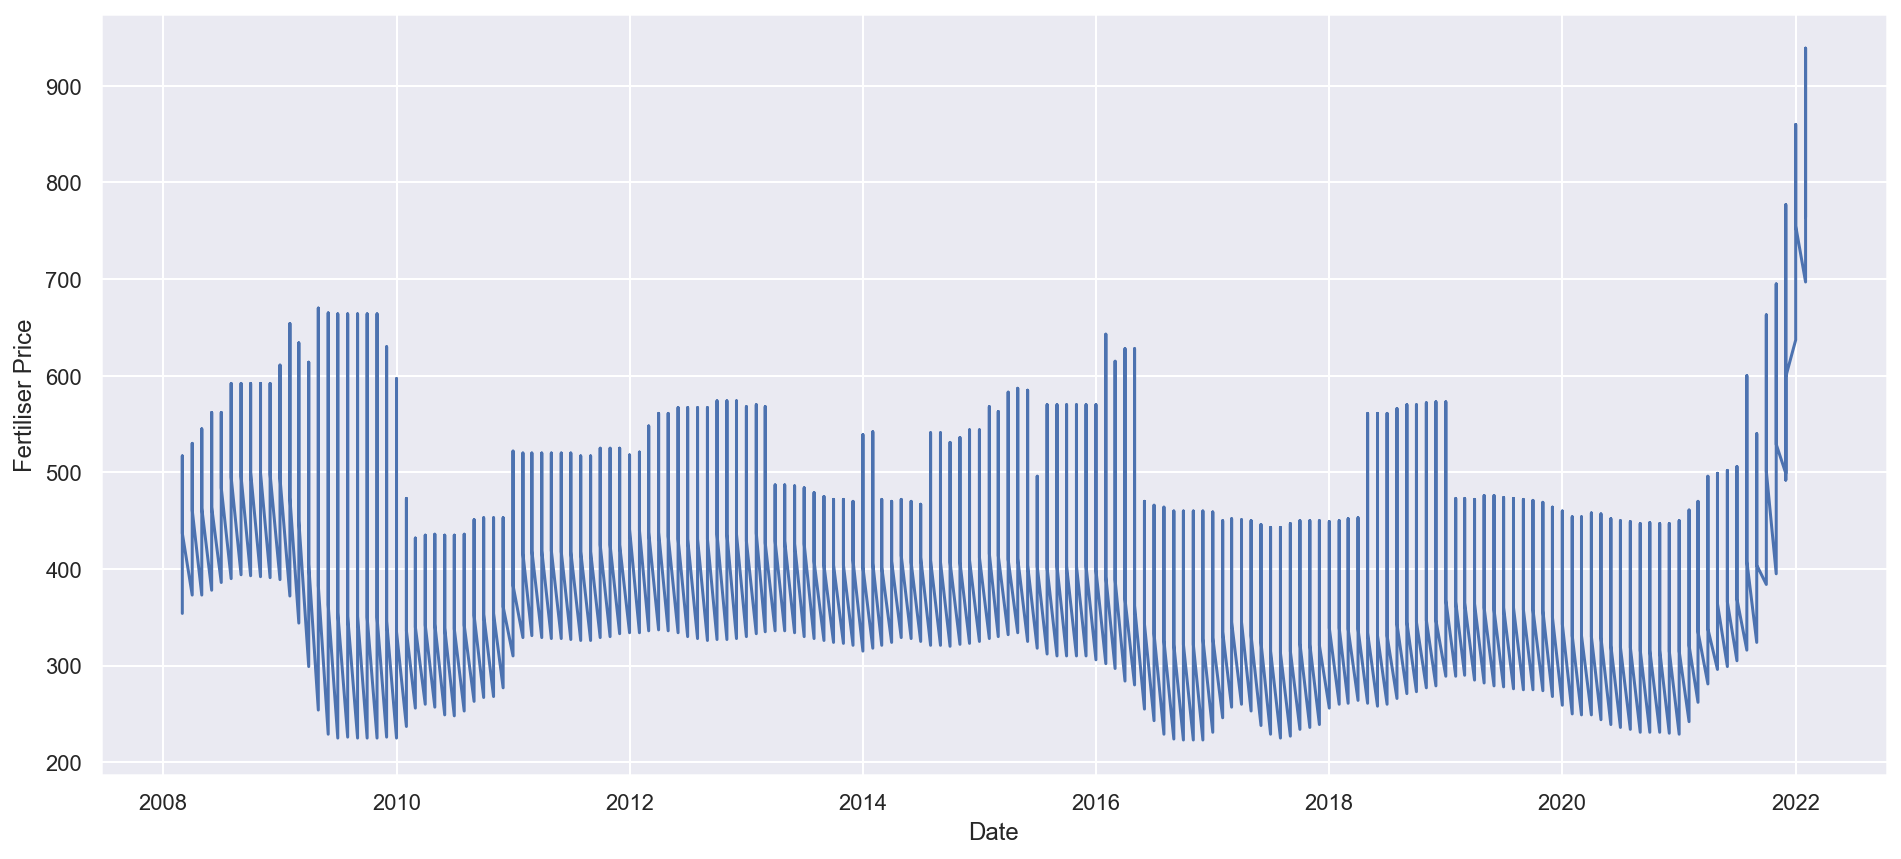

In [57]:
#Data Exploration
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Date')
ax1.set_ylabel('Fertiliser Price')
ax1.plot(df_oneyear['value'])

<Figure size 1152x504 with 0 Axes>

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

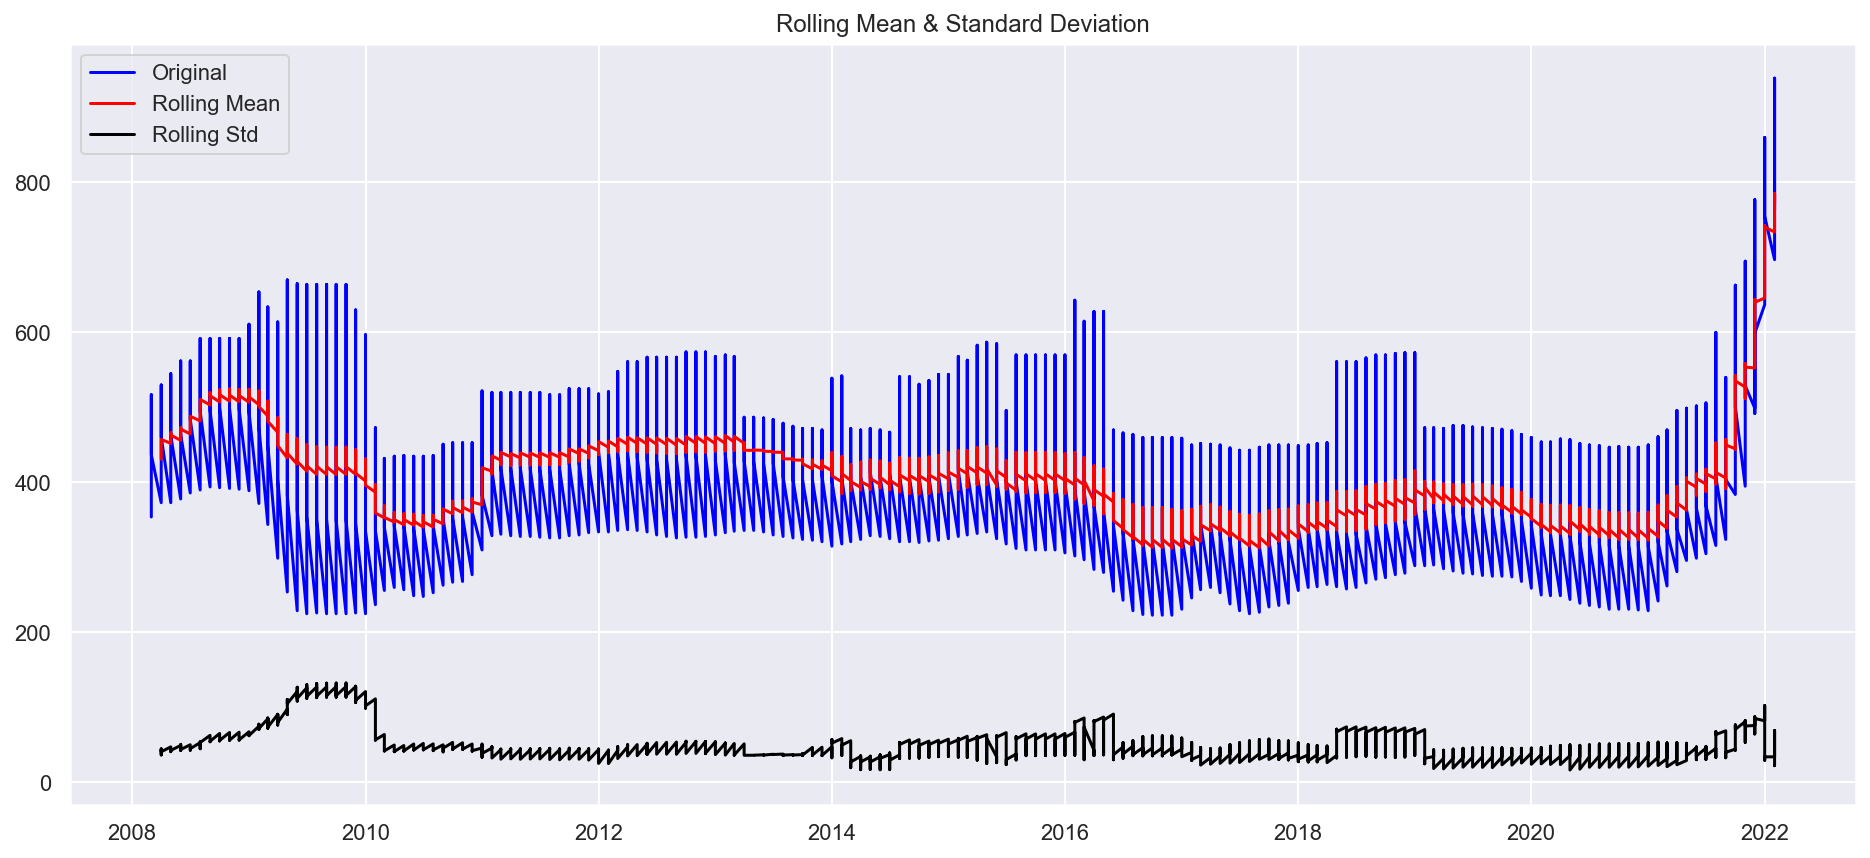

In [58]:
#Determing rolling statistics
rolLmean = df_oneyear['value'].rolling(12).mean()
rolLstd = df_oneyear['value'].rolling(12).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(df_oneyear['value'], color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

<Figure size 1152x504 with 0 Axes>

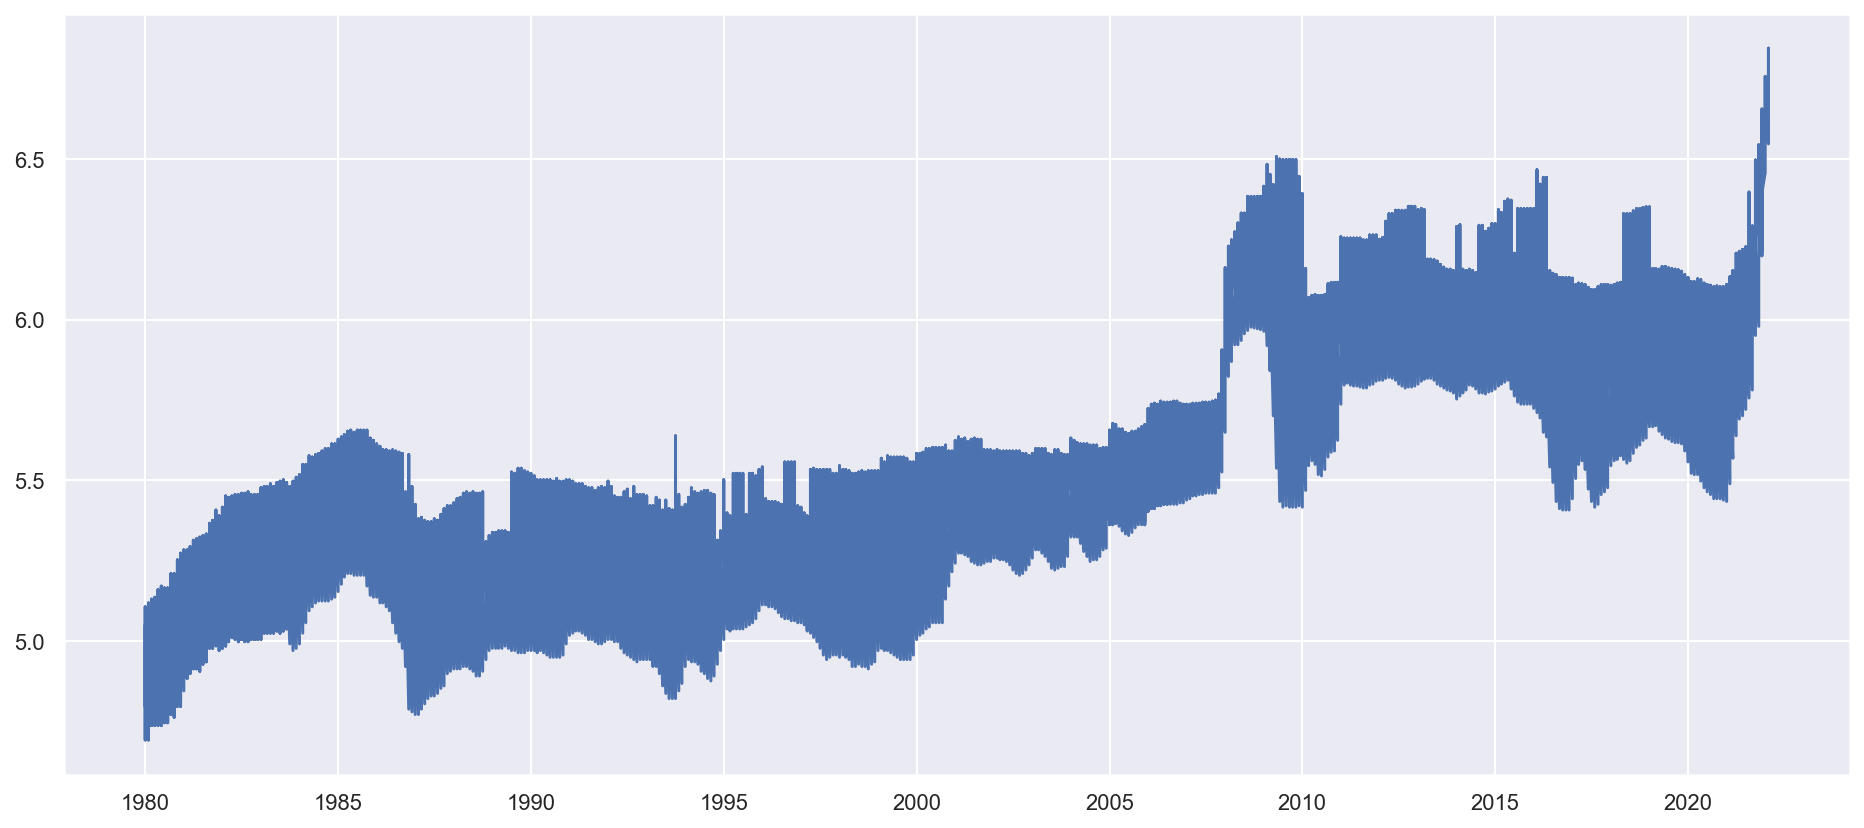

In [88]:
#Lets try transformation
plt.figure(figsize=(16,7))
fig = plt.figure(1)

import numpy as np
ts_log = np.log(df_fertiliser['value'])
plt.plot(ts_log)

In [89]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, freq=1, model = 'multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

TypeError: seasonal_decompose() got an unexpected keyword argument 'freq'

In [ ]:
#Lets try differencing
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

#Determing rolling statistics
rolLmean = ts_log_diff.rolling(12).mean()
rolLstd = ts_log_diff.rolling(12).std()




#Plot rolling statistics:
orig = plt.plot(ts_log_diff, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [90]:
df_fertiliser.sort_index(inplace= True)

In [91]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20)

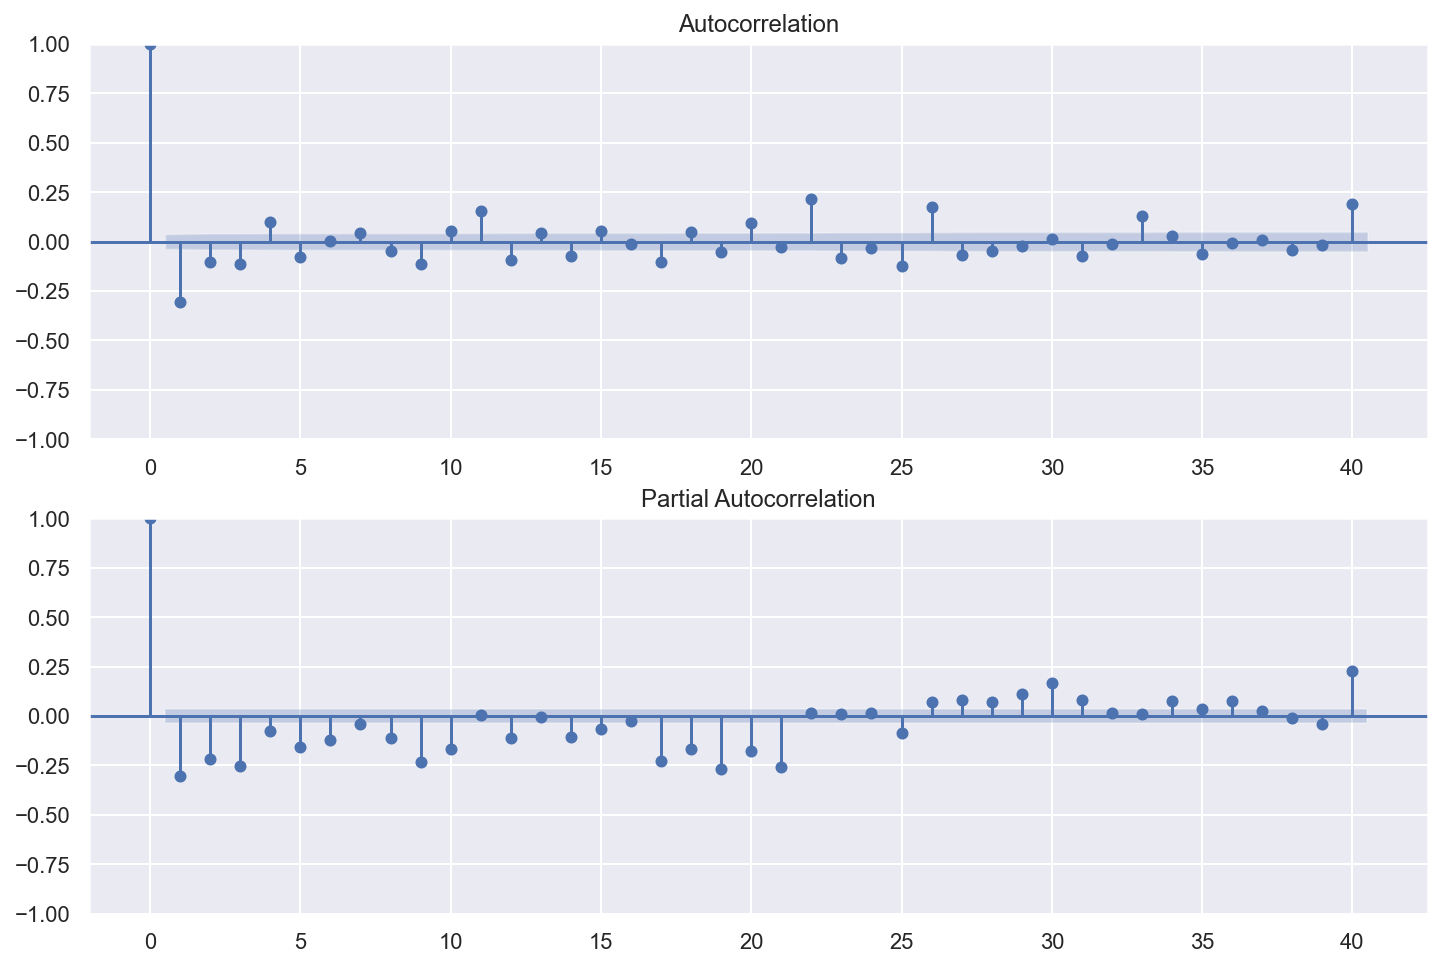

In [92]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_log_diff.dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_log_diff.dropna(),lags=40,ax=ax2)

In [93]:
from statsmodels.tsa.arima.model import ARIMA

In [94]:
type(ts_log_diff)

pandas.core.series.Series

In [95]:
#ts_log_diff.dropna()
ts_log_diff = ts_log_diff[~ts_log_diff.isnull()]

<Figure size 1152x576 with 0 Axes>

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


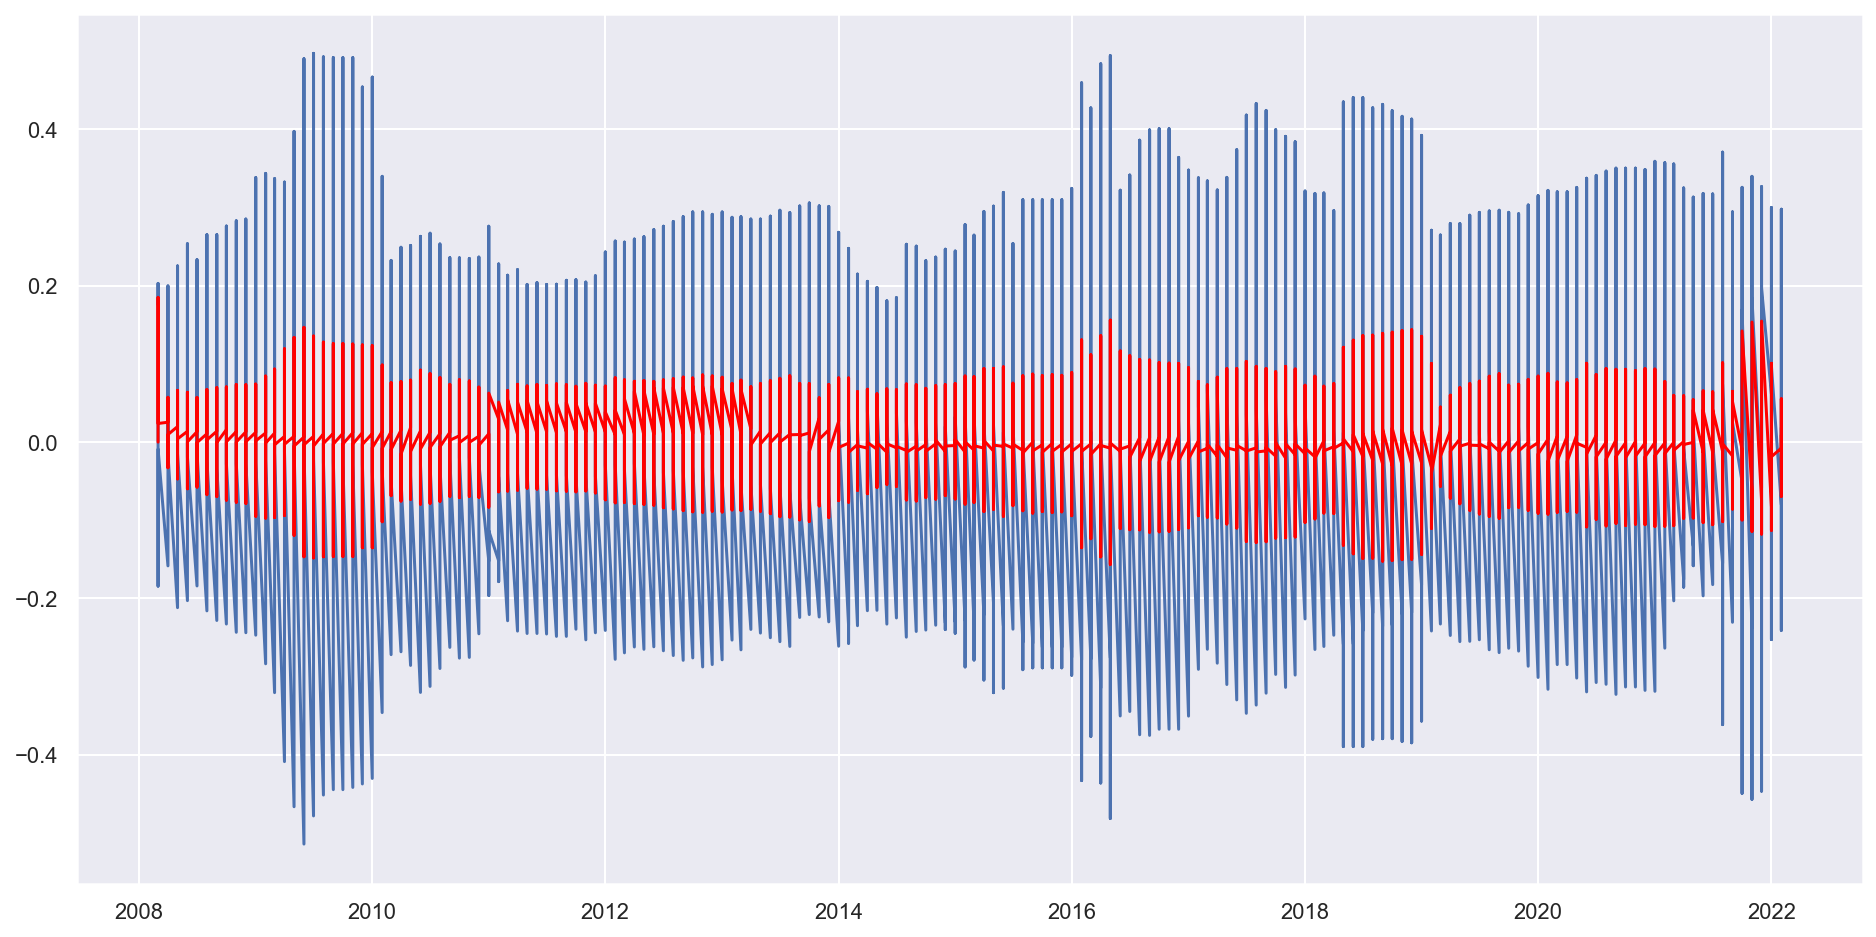

In [96]:
plt.figure(figsize=(16,8))
#ts_log_diff.dropna(inplace=True)
model = ARIMA(ts_log_diff, order=(2,1,2))  
results_ARIMA = model.fit()  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [97]:
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())

date
2008-03-01    0.000000
2008-03-01    0.175708
2008-03-01    0.185078
2008-03-01    0.156957
2008-03-01    0.056001
dtype: float64


In [98]:
ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()
print(ARIMA_diff_predictions_cumsum.head())

date
2008-03-01    0.000000
2008-03-01    0.175708
2008-03-01    0.360786
2008-03-01    0.517743
2008-03-01    0.573744
dtype: float64


In [99]:
ARIMA_log_prediction = pd.Series(ts_log.iloc[0], index=ts_log.index)
ARIMA_log_prediction = ARIMA_log_prediction.add(ARIMA_diff_predictions_cumsum,fill_value=0)
ARIMA_log_prediction.head()

date
1980-01-01    4.795791
1980-01-01    4.795791
1980-01-01    4.795791
1980-01-01    4.795791
1980-01-01    4.795791
dtype: float64

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'RMSE: 5773.4179')

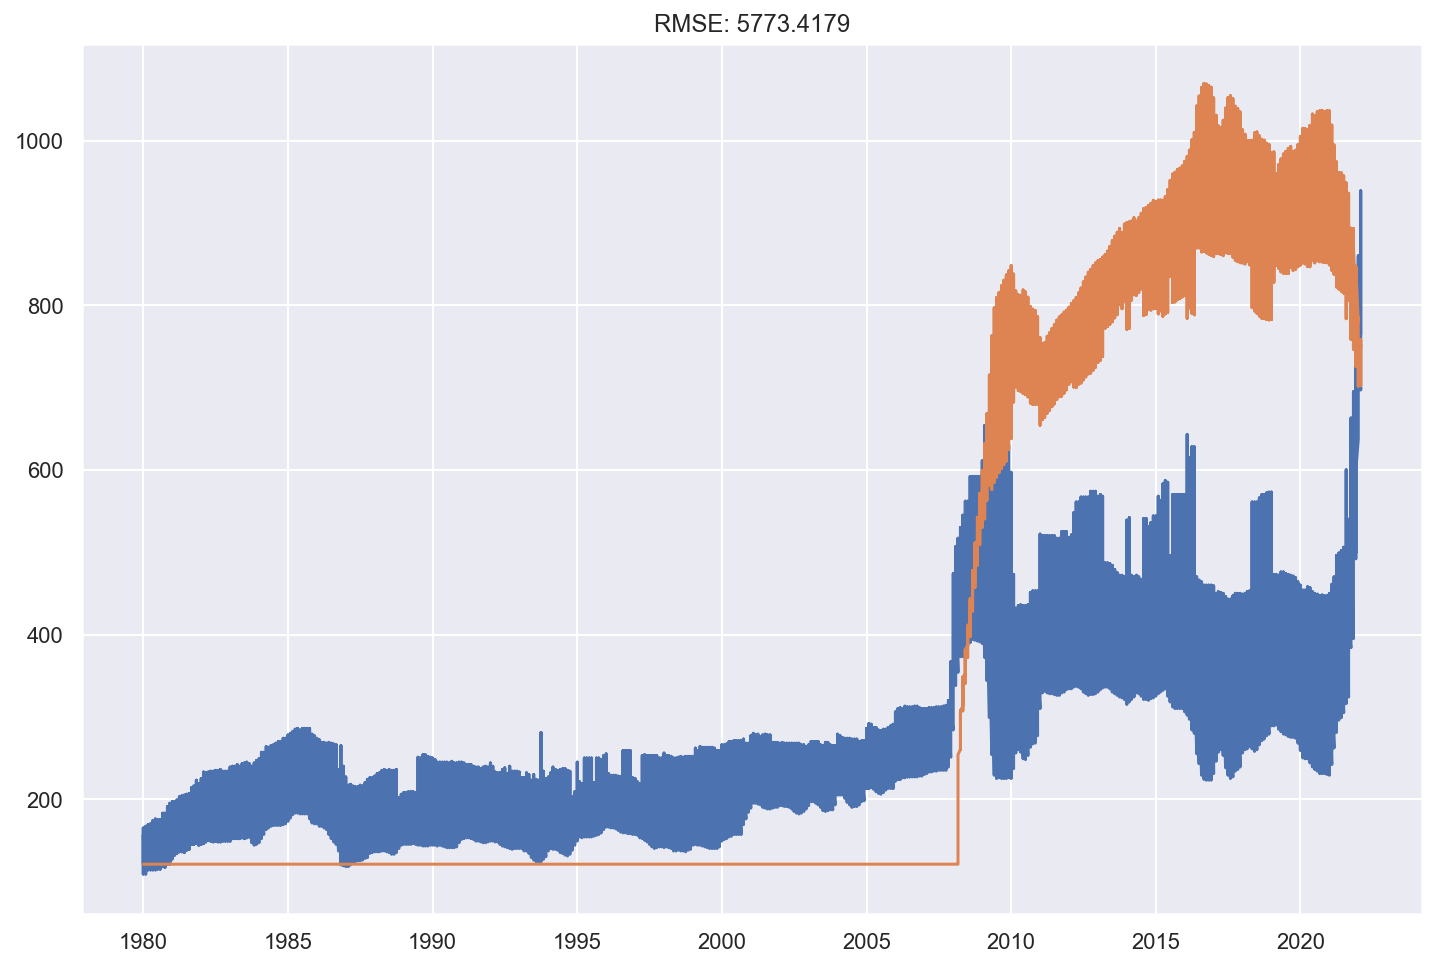

In [100]:
plt.figure(figsize=(12,8))
predictions_ARIMA = np.exp(ARIMA_log_prediction)
plt.plot(df_fertiliser['value'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-df_fertiliser['value'])**2)/len(df_fertiliser['value'])))

# Sentiment analysis of tweets

In [8]:
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text
0,0,2022-04-27 08:42:30+00:00,1519235527324712960,‘Surging input costs are keeping #farmers awak...
1,1,2022-04-02 17:15:52+00:00,1510305024081117190,@jerwaugh @youngsiward Would you not agree tha...
2,2,2022-02-27 16:15:11+00:00,1497968564069879813,@libraryturner @lidl_ireland Don’t get used to...
3,3,2021-12-01 15:46:31+00:00,1466071216813395972,@AgrilandIreland Please show how many Irish Fa...


In [9]:
# convert to datetime
df_tweets['Datetime'] = pd.to_datetime(df_tweets['Datetime']).dt.date

In [10]:
# convert the date column to date format
df_tweets['Datetime'] = df_tweets['Datetime'].apply(pd.to_datetime)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  4 non-null      int64         
 1   Datetime    4 non-null      datetime64[ns]
 2   Tweet Id    4 non-null      int64         
 3   Text        4 non-null      object        
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 256.0+ bytes


In [13]:
df_tweets = df_tweets[(df_tweets['Datetime'] > "2022-01-01") & (df_tweets['Datetime'] < "2022-04-29")]

In [14]:
#get the word count of the tweet
df_tweets["word_count"] = df_tweets["Text"].apply(lambda x: len(str(x).split()))

In [15]:
#get the word count of the tweet
df_tweets["char_count"] = df_tweets["Text"].str.len()

### Natural Language processing

### Topic modelling
https://www.youtube.com/watch?v=NYkbqzTlW3w
https://www.youtube.com/watch?v=VraAbgAoYSk

In [16]:
#https://www.nltk.org/
import nltk #natural langugage toolkit

In [17]:
#download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritaraher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from nltk.corpus import stopwords
#remove stopwords
stop = stopwords.words("english")

In [19]:
# counting stop words
#stop words
df_tweets["stopwords"]= df_tweets["Text"].apply(lambda x: len([x for x in x.split() if x in stop]))

In [20]:
#count hashtags
df_tweets["hashtag"]= df_tweets["Text"].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

In [22]:
# Apply text cleaning techniques
import re
import string

def clean_text_round1(text):
    text = text.lower()                                              #lowercase
    text = re.sub('\[.*?\]', '', text)                               #remove the twitter handle
    text = re.sub('@[^\s]+', '', text)                               # remove text in square brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # remove punctuation
    text = re.sub('\w*\d\w*', '', text)                              #remove words containing numbers
    text = re.sub('\n', '', text)                                    # remove \n
    return text

round1 = lambda x: clean_text_round1(x)

In [23]:
# Let's take a look at the updated text
df_tweets['tweet_clean'] = df_tweets.Text.apply(round1)
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text,word_count,char_count,stopwords,hashtag,tweet_clean
0,0,2022-04-27,1519235527324712960,‘Surging input costs are keeping #farmers awak...,17,139,2,3,‘surging input costs are keeping farmers awake...
1,1,2022-04-02,1510305024081117190,@jerwaugh @youngsiward Would you not agree tha...,44,259,20,0,would you not agree that if you owned a wind...
2,2,2022-02-27,1497968564069879813,@libraryturner @lidl_ireland Don’t get used to...,28,169,9,0,don’t get used to it costs are rising to muc...


In [24]:
#removing stop words from tweet clean
df_tweets["tweet_clean"]= df_tweets["tweet_clean"].apply(lambda x : " ".join(x for x in x.split() if x not in stop))

### Sentiment Analysis with TextBlob

In [25]:
##semantic analysis
from textblob import TextBlob
df_tweets["tweet_clean"][:5].apply(lambda x : TextBlob(x).sentiment)

#   (-0.5, 1.0)
# sentiment of being negative because of the -, subjective

0                                   (0.0, 0.0)
1    (0.05333333333333334, 0.6133333333333334)
2                                   (0.1, 0.6)
Name: tweet_clean, dtype: object

In [26]:
df_tweets["polarity"]= df_tweets["tweet_clean"].apply(lambda x : TextBlob(x).sentiment[0])

#   (-0.5, 1.0)
# sentiment of being negative because of the -, subjective

In [27]:
df_tweets["subjectivity"]= df_tweets["tweet_clean"].apply(lambda x : TextBlob(x).sentiment[1])

In [28]:
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text,word_count,char_count,stopwords,hashtag,tweet_clean,polarity,subjectivity
0,0,2022-04-27,1519235527324712960,‘Surging input costs are keeping #farmers awak...,17,139,2,3,‘surging input costs keeping farmers awake nig...,0.000000,0.000000
1,1,2022-04-02,1510305024081117190,@jerwaugh @youngsiward Would you not agree tha...,44,259,20,0,would agree owned wind farm ccgt would making ...,0.053333,0.613333
2,2,2022-02-27,1497968564069879813,@libraryturner @lidl_ireland Don’t get used to...,28,169,9,0,don’t get used costs rising much farm level it...,0.100000,0.600000


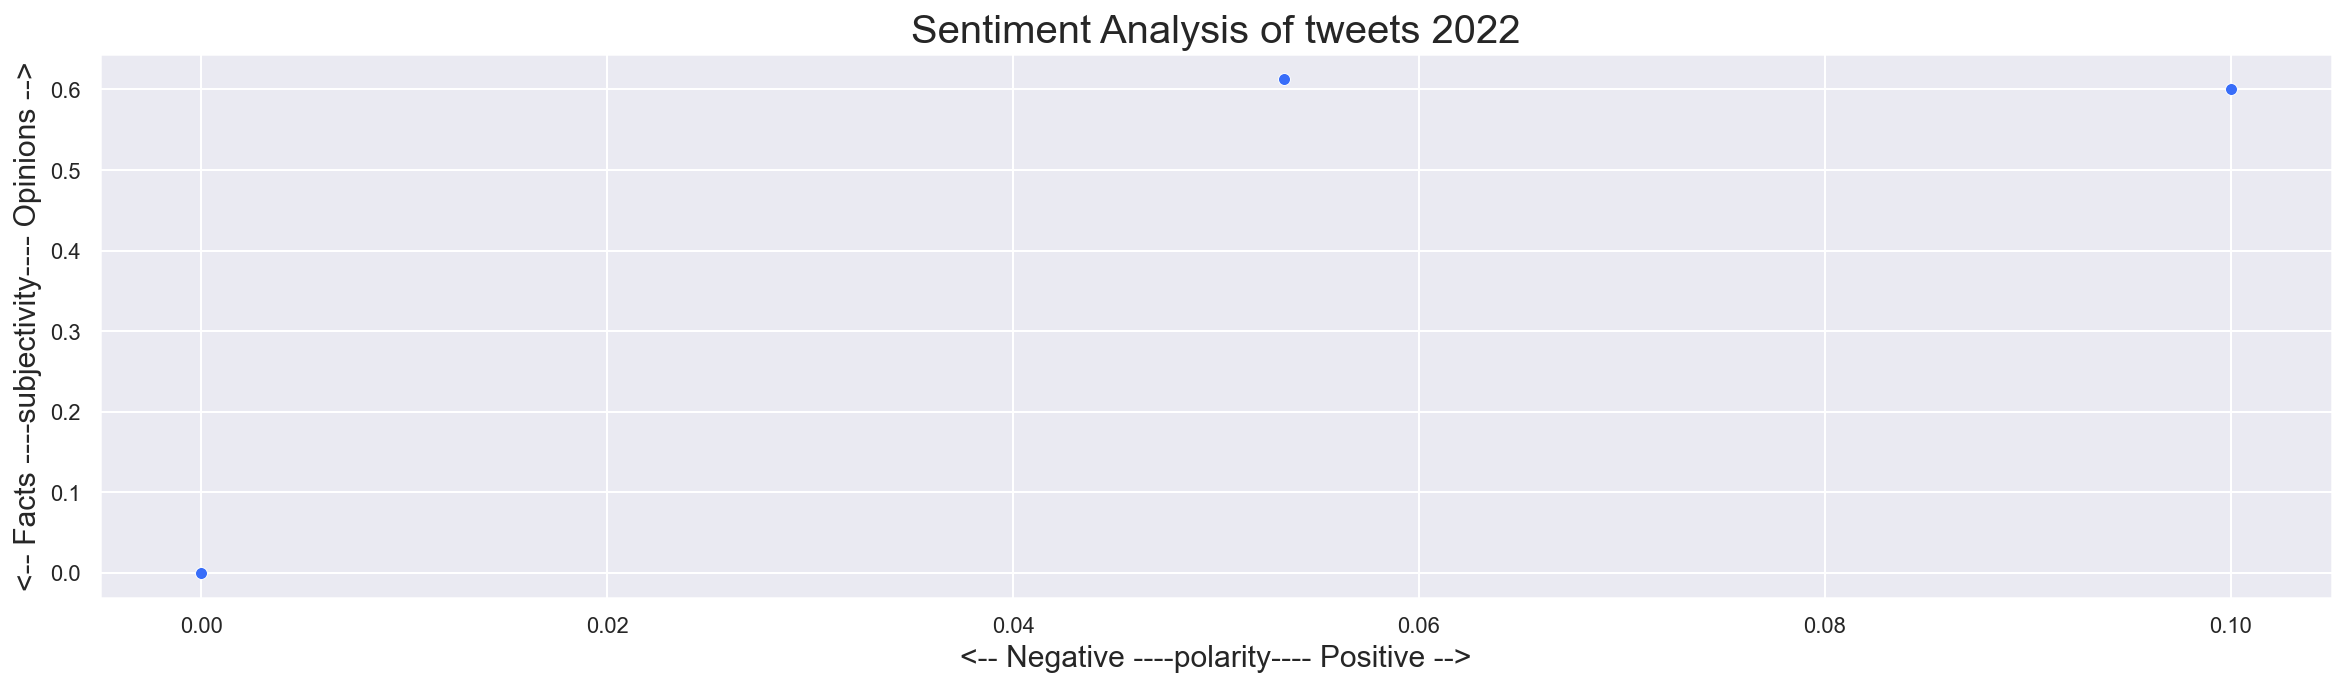

In [29]:
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(20, 5));  

sns.scatterplot(data=df_tweets, x="polarity", y="subjectivity")

plt.title("Sentiment Analysis of tweets 2022", fontsize=20);
plt.xlabel('<-- Negative ----polarity---- Positive -->', fontsize=15);
plt.ylabel('<-- Facts ----subjectivity---- Opinions -->', fontsize=15);

plt.show();

### Document term matrix

https://analyticsindiamag.com/a-guide-to-term-document-matrix-with-its-implementation-in-r-and-python/

In [30]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words="english")
data_cv = cv.fit_transform(df_tweets['tweet_clean'])
data_dtm =pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())

# Pickle it for later use
import pickle
pickle.dump(cv, open("../data/cv_stop.pkl", "wb"))

data_dtm

,agree,agribusiness,awake,bear,ccgt,consumers,cost,costs,don,electricity,...,profits,report,rise,rising,store,superprofits,surging,used,wholesale,wind
0,0,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,1,0,0,1,1,1,1,1,0,1,...,1,0,0,0,0,1,0,0,1,1
2,0,0,0,0,0,0,0,1,1,0,...,0,0,1,1,1,0,0,1,0,0


In [31]:
#Gensism Python framework for fast Vector Space Modelling
from gensim import matutils, models
#ndustrial-strength Natural Language Processing (NLP) in Python
import scipy.sparse

### Topic modelling

In [32]:
# One of the required inputs is a term-document matrix
data_dtm = data_dtm.transpose()
data_dtm.head()

,0,1,2
agree,0,1,0
agribusiness,1,0,0
awake,1,0,0
bear,0,1,0
ccgt,0,1,0


In [33]:
# turn term matrix into a sparse matrix
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [34]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
#cv = pickle.load(open("../data/cv_stop.pkl", "rb"))

In [35]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [36]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.051*"costs" + 0.051*"farm" + 0.030*"production" + 0.030*"consumers" + 0.030*"agree" + 0.030*"electricity" + 0.030*"wind" + 0.030*"profits" + 0.030*"ccgt" + 0.030*"making"'),
 (1,
  '0.051*"prices" + 0.051*"farm" + 0.051*"costs" + 0.051*"inevitable" + 0.051*"store" + 0.051*"know" + 0.051*"used" + 0.051*"level" + 0.051*"rise" + 0.051*"rising"')]

In [37]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.055*"farm" + 0.055*"costs" + 0.055*"surging" + 0.055*"farmers" + 0.055*"agribusiness" + 0.055*"report" + 0.055*"awake" + 0.055*"ifac" + 0.055*"night" + 0.055*"input"'),
 (1,
  '0.055*"prices" + 0.055*"costs" + 0.055*"farm" + 0.032*"inevitable" + 0.032*"rise" + 0.032*"used" + 0.032*"know" + 0.032*"don" + 0.032*"level" + 0.032*"store"'),
 (2,
  '0.027*"costs" + 0.027*"keeping" + 0.027*"irish" + 0.027*"input" + 0.027*"night" + 0.027*"ifac" + 0.027*"awake" + 0.027*"report" + 0.027*"farm" + 0.027*"agribusiness"')]

In [38]:
# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.027*"high" + 0.027*"profits" + 0.027*"massive" + 0.027*"making" + 0.027*"low" + 0.027*"cost" + 0.027*"bear" + 0.027*"wind" + 0.027*"electricity" + 0.027*"wholesale"'),
 (1,
  '0.027*"costs" + 0.027*"farm" + 0.027*"rising" + 0.027*"don" + 0.027*"store" + 0.027*"know" + 0.027*"used" + 0.027*"rise" + 0.027*"level" + 0.027*"inevitable"'),
 (2,
  '0.057*"prices" + 0.057*"costs" + 0.057*"farm" + 0.032*"rise" + 0.032*"know" + 0.032*"level" + 0.032*"don" + 0.032*"inevitable" + 0.032*"store" + 0.032*"used"'),
 (3,
  '0.059*"farm" + 0.059*"costs" + 0.059*"input" + 0.059*"report" + 0.059*"ifac" + 0.059*"surging" + 0.059*"farmers" + 0.059*"irish" + 0.059*"keeping" + 0.059*"agribusiness"')]

### Topic Modeling - Attempt #2 (Nouns Only)

In [39]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [40]:
# Apply the nouns function to the transcripts to filter only on nouns
df_tweets['data_nouns'] = pd.DataFrame(df_tweets.tweet_clean.apply(nouns))
df_tweets

,Unnamed: 0,Datetime,Tweet Id,Text,word_count,char_count,stopwords,hashtag,tweet_clean,polarity,subjectivity,data_nouns
0,0,2022-04-27,1519235527324712960,‘Surging input costs are keeping #farmers awak...,17,139,2,3,‘surging input costs keeping farmers awake nig...,0.000000,0.000000,‘ input costs farmers night ’ ifac farm report...
1,1,2022-04-02,1510305024081117190,@jerwaugh @youngsiward Would you not agree tha...,44,259,20,0,would agree owned wind farm ccgt would making ...,0.053333,0.613333,farm ccgt profits prices production cost elect...
2,2,2022-02-27,1497968564069879813,@libraryturner @lidl_ireland Don’t get used to...,28,169,9,0,don’t get used costs rising much farm level it...,0.100000,0.600000,don ’ t costs farm level prices rise


In [41]:
df_tweets.data_nouns

0    ‘ input costs farmers night ’ ifac farm report...
1    farm ccgt profits prices production cost elect...
2                 don ’ t costs farm level prices rise
Name: data_nouns, dtype: object

In [44]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said', 'amp']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(df_tweets.data_nouns)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())

data_dtmn

,agribusiness,ccgt,consumers,cost,costs,don,electricity,farm,farmers,ifac,input,level,night,prices,production,profits,report,rise,superprofits
0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,1,0,0
1,0,1,1,1,1,0,1,1,0,0,0,0,0,1,1,1,0,0,1
2,0,0,0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,1,0


In [45]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [46]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.098*"prices" + 0.098*"costs" + 0.098*"farm" + 0.059*"ccgt" + 0.059*"production" + 0.059*"electricity" + 0.059*"profits" + 0.059*"cost" + 0.059*"consumers" + 0.059*"superprofits"'),
 (1,
  '0.086*"farm" + 0.086*"costs" + 0.085*"agribusiness" + 0.085*"farmers" + 0.085*"ifac" + 0.085*"input" + 0.085*"night" + 0.085*"report" + 0.029*"rise" + 0.029*"don"')]

In [47]:
# Let's try topics = 3
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.115*"farm" + 0.115*"costs" + 0.066*"ifac" + 0.066*"agribusiness" + 0.066*"night" + 0.066*"input" + 0.066*"farmers" + 0.066*"report" + 0.066*"don" + 0.066*"rise"'),
 (1,
  '0.082*"prices" + 0.082*"costs" + 0.082*"farm" + 0.082*"production" + 0.082*"electricity" + 0.082*"consumers" + 0.082*"cost" + 0.082*"profits" + 0.082*"superprofits" + 0.082*"ccgt"'),
 (2,
  '0.053*"prices" + 0.053*"farm" + 0.053*"costs" + 0.053*"level" + 0.053*"rise" + 0.053*"don" + 0.053*"report" + 0.053*"farmers" + 0.053*"agribusiness" + 0.053*"input"')]

In [48]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.085*"prices" + 0.085*"consumers" + 0.085*"electricity" + 0.085*"production" + 0.085*"profits" + 0.085*"superprofits" + 0.085*"cost" + 0.085*"farm" + 0.085*"ccgt" + 0.085*"costs"'),
 (1,
  '0.053*"prices" + 0.053*"costs" + 0.053*"farm" + 0.053*"level" + 0.053*"don" + 0.053*"rise" + 0.053*"farmers" + 0.053*"night" + 0.053*"agribusiness" + 0.053*"input"'),
 (2,
  '0.120*"costs" + 0.120*"farm" + 0.067*"agribusiness" + 0.067*"input" + 0.067*"ifac" + 0.067*"report" + 0.067*"night" + 0.067*"farmers" + 0.067*"rise" + 0.067*"don"'),
 (3,
  '0.053*"costs" + 0.053*"prices" + 0.053*"farm" + 0.053*"ccgt" + 0.053*"profits" + 0.053*"cost" + 0.053*"superprofits" + 0.053*"production" + 0.053*"electricity" + 0.053*"consumers"')]

### Topic Modeling - Attempt #3 (Nouns and Adjectives)

In [50]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [51]:
# Apply the nouns function to the transcripts to filter only on nouns
df_tweets['data_nouns_adj'] = pd.DataFrame(df_tweets.tweet_clean.apply(nouns_adj))

In [52]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(df_tweets.data_nouns_adj)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())

data_dtmna

,agribusiness,ccgt,consumers,cost,don,electricity,farmers,high,ifac,inevitable,...,low,massive,night,prices,production,profits,report,rise,superprofits,wholesale
0,1,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,0,1,1,1,0,1,0,1,0,0,...,1,1,0,1,1,1,0,0,1,1
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0


In [53]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())


In [54]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.064*"input" + 0.064*"report" + 0.064*"irish" + 0.064*"ifac" + 0.064*"night" + 0.064*"farmers" + 0.064*"agribusiness" + 0.064*"inevitable" + 0.064*"don" + 0.064*"rise"'),
 (1,
  '0.065*"prices" + 0.064*"cost" + 0.064*"ccgt" + 0.064*"massive" + 0.064*"high" + 0.064*"profits" + 0.064*"electricity" + 0.064*"low" + 0.064*"wholesale" + 0.064*"superprofits"')]

In [55]:
# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.105*"prices" + 0.105*"rise" + 0.105*"inevitable" + 0.105*"level" + 0.105*"don" + 0.026*"farmers" + 0.026*"night" + 0.026*"irish" + 0.026*"report" + 0.026*"ifac"'),
 (1,
  '0.068*"prices" + 0.068*"consumers" + 0.068*"electricity" + 0.068*"high" + 0.068*"ccgt" + 0.068*"massive" + 0.068*"low" + 0.068*"profits" + 0.068*"wholesale" + 0.068*"production"'),
 (2,
  '0.091*"agribusiness" + 0.091*"ifac" + 0.091*"input" + 0.091*"irish" + 0.091*"report" + 0.091*"night" + 0.091*"farmers" + 0.023*"prices" + 0.023*"don" + 0.023*"rise"')]

In [56]:
# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.044*"prices" + 0.043*"rise" + 0.043*"production" + 0.043*"inevitable" + 0.043*"level" + 0.043*"don" + 0.043*"superprofits" + 0.043*"high" + 0.043*"low" + 0.043*"agribusiness"'),
 (1,
  '0.044*"prices" + 0.043*"rise" + 0.043*"inevitable" + 0.043*"don" + 0.043*"level" + 0.043*"agribusiness" + 0.043*"ifac" + 0.043*"night" + 0.043*"irish" + 0.043*"input"'),
 (2,
  '0.071*"prices" + 0.070*"profits" + 0.070*"ccgt" + 0.070*"electricity" + 0.070*"cost" + 0.070*"wholesale" + 0.070*"low" + 0.070*"consumers" + 0.070*"massive" + 0.070*"high"'),
 (3,
  '0.070*"farmers" + 0.070*"irish" + 0.070*"report" + 0.070*"input" + 0.070*"night" + 0.070*"ifac" + 0.070*"agribusiness" + 0.070*"don" + 0.070*"level" + 0.070*"inevitable"')]

### Identify Topics in Each Document

In [57]:
# final LDA model (for now)
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=80)
ldana.print_topics()

[(0,
  '0.098*"ifac" + 0.098*"irish" + 0.098*"report" + 0.098*"night" + 0.098*"input" + 0.098*"agribusiness" + 0.098*"farmers" + 0.020*"prices" + 0.020*"inevitable" + 0.020*"rise"'),
 (1,
  '0.070*"high" + 0.070*"superprofits" + 0.070*"massive" + 0.070*"low" + 0.070*"ccgt" + 0.070*"wholesale" + 0.070*"profits" + 0.070*"consumers" + 0.070*"cost" + 0.070*"electricity"'),
 (2,
  '0.043*"prices" + 0.043*"inevitable" + 0.043*"rise" + 0.043*"don" + 0.043*"level" + 0.043*"irish" + 0.043*"report" + 0.043*"night" + 0.043*"input" + 0.043*"agribusiness"'),
 (3,
  '0.116*"prices" + 0.116*"inevitable" + 0.116*"rise" + 0.116*"don" + 0.116*"level" + 0.023*"irish" + 0.023*"report" + 0.023*"night" + 0.023*"input" + 0.023*"agribusiness"')]